In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import SimpleITK as sitk
from tqdm import tqdm
from timeit import default_timer as timer
from data_tools.itk import *
plt.rcParams["figure.figsize"] = (20,5)
sitk.ProcessObject_SetGlobalWarningDisplay(False)

In [3]:
# get data dir
TRAIN_DIR = "./data/train/" 
IMAGE_DIRS = get_dir_dict(TRAIN_DIR)

In [4]:
def mean_spacings(series_list):
    x_dim = []
    y_dim = [] 
    z_dim = []
    # sitk read all flair images and rotate
    for i in tqdm(series_list):
        # read sitk image 
        image = read_dicom_series(i)
        # rotate image
        image = rotate_image(image)
        # get spacings 
        sx, sy, sz = image.GetSpacing()

        x_dim.append(sx)
        y_dim.append(sy)
        z_dim.append(sz)
    return np.mean(x_dim), np.mean(y_dim), np.mean(z_dim)
    

In [5]:
print(mean_spacings(IMAGE_DIRS["flair"]))
print(mean_spacings(IMAGE_DIRS["t1w"]))
print(mean_spacings(IMAGE_DIRS["t1wce"]))
print(mean_spacings(IMAGE_DIRS["t2w"]))

In [9]:
os.path.basename(os.path.dirname(IMAGE_DIRS["flair"][0]))

'00494'

In [21]:
this = np.load("./processed/train/00122/FLAIR.npy", allow_pickle=True)

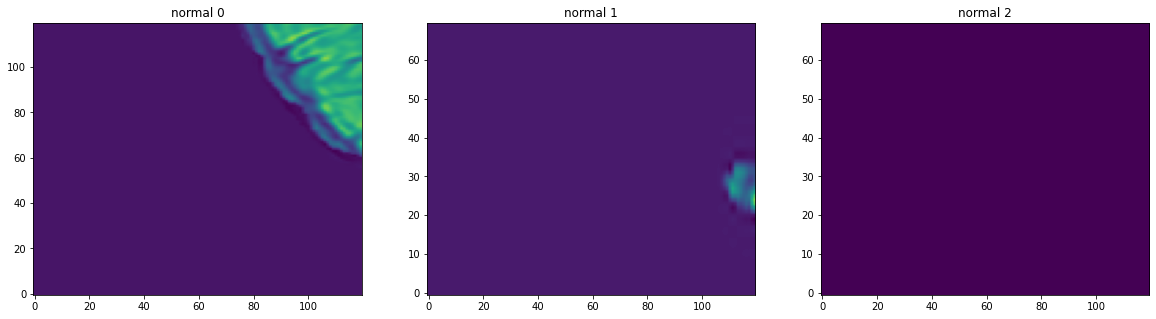

In [22]:
that = sitk.GetImageFromArray(this)
show_image(that)

### Construct dataset list

In [61]:
data_dict = { "flair":[], "t1w":[], "t1wce":[], "t2w":[] , "label":[]}
data_path = "./data/train/"

In [62]:
label_df = pd.read_csv("./data/train_labels.csv", index_col=0, dtype=np.str_)
label_dict = label_df.to_dict()["MGMT_value"]

In [63]:
# walk through path 
pid = [data_path + p for p in next(os.walk(data_path))[1]]
for p in pid:
    # get label from patient id
    p_hash = int(os.path.basename(p))
    data_dict["label"].append(label_dict[p_hash])
    for im in next(os.walk(p))[2]:
        imtype = os.path.splitext(im)[0].lower()
        data_dict[imtype].append(p + "/" + im)

In [64]:
# construct dataframe from dict and save( no header or idx)
df = pd.DataFrame.from_dict(data_dict)
df.to_csv("./nii_data_paths.csv", header=False, index=False)
df.head()

,flair,t1w,t1wce,t2w,label
0,./data/train/00494/FLAIR.nii,./data/train/00494/T1w.nii,./data/train/00494/T1wCE.nii,./data/train/00494/T2w.nii,1
1,./data/train/00441/FLAIR.nii,./data/train/00441/T1w.nii,./data/train/00441/T1wCE.nii,./data/train/00441/T2w.nii,0
2,./data/train/00661/FLAIR.nii,./data/train/00661/T1w.nii,./data/train/00661/T1wCE.nii,./data/train/00661/T2w.nii,1
3,./data/train/00426/FLAIR.nii,./data/train/00426/T1w.nii,./data/train/00426/T1wCE.nii,./data/train/00426/T2w.nii,1
4,./data/train/00035/FLAIR.nii,./data/train/00035/T1w.nii,./data/train/00035/T1wCE.nii,./data/train/00035/T2w.nii,1


In [71]:
X = np.loadtxt("./nii_data_paths.csv", 
                     dtype=np.str_,
                     unpack=True,
                     delimiter=",")

In [74]:
type(list(X[0][1]))

list

In [76]:
import torch_tools.datasets as datasets

In [90]:
test = datasets.flair_dataset("./nii_data_paths.csv")

In [91]:
idx = [1,2,3]

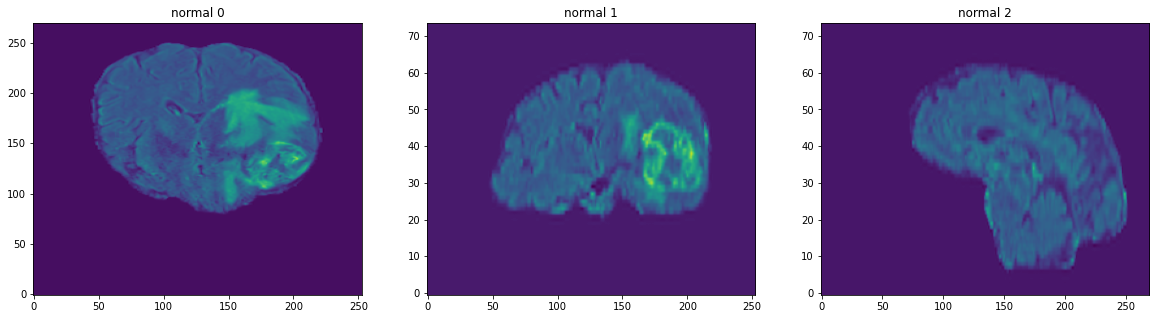

In [102]:
show_image(sitk.GetImageFromArray(test[idx][0][2]))

In [103]:
test[idx][2]

array(['./data/train/00441/FLAIR.nii', './data/train/00661/FLAIR.nii',
       './data/train/00426/FLAIR.nii'], dtype='<U28')

In [104]:
test[idx][1]

array([0, 1, 1])